# Vizualisation of the track infrastructure in curves of Malmbanan

## Reading input data

We start by reading data from all the bandelar 111, 113, 116-119 with filenames in the form of RPM Rälslitage i kurva_111.csv. We then combine them into one dataframe.

In [61]:
import pandas as pd
import glob

# Step 1: Define the file path and pattern
file_pattern = "RPM Rälslitage i kurva_*.csv"

# Step 2: Read all files matching the pattern
file_list = glob.glob(file_pattern)

# Step 3: Create a dictionary to store DataFrames
dataframes = {}

for file in file_list:
    try:
        # Extract a unique key for each DataFrame (e.g., from the filename)
        key = file.split("_")[-1].replace(".csv", "")  # Extract part of the filename for identification
        # Read the CSV file into a DataFrame with ; as the delimiter
        df = pd.read_csv(file, delimiter=';', encoding='ISO-8859-1')  # Adjust encoding if needed
        # Store the DataFrame in the dictionary
        dataframes[key] = df
        print(f"Successfully loaded {file} into DataFrame with key '{key}'")
    except Exception as e:
        print(f"Error reading {file}: {e}")

Successfully loaded RPM Rälslitage i kurva_111.csv into DataFrame with key '111'
Successfully loaded RPM Rälslitage i kurva_113.csv into DataFrame with key '113'
Successfully loaded RPM Rälslitage i kurva_116.csv into DataFrame with key '116'
Successfully loaded RPM Rälslitage i kurva_117.csv into DataFrame with key '117'
Successfully loaded RPM Rälslitage i kurva_118.csv into DataFrame with key '118'
Successfully loaded RPM Rälslitage i kurva_119.csv into DataFrame with key '119'


In [62]:
# Combine all DataFrames in the dictionary into a single DataFrame
try:
    combined_dataframe = pd.concat(dataframes.values(), ignore_index=True)
    print("Successfully combined all DataFrames into one.")
except Exception as e:
    print(f"Error combining DataFrames: {e}")

Successfully combined all DataFrames into one.


## Cleaning and preprocessing

We need to process some columns to get correct format of info.

In [63]:
import re
import numpy as np

# Correct formatting of 'Medel Spårvidd Cirkulärkurva' to numeric
combined_dataframe['Medel Spårvidd Cirkulärkurva'] = combined_dataframe['Medel Spårvidd Cirkulärkurva'].str.replace(',', '.').astype(float)

combined_dataframe['Startläge'] = combined_dataframe['Startläge'].str.replace(',', '.')
combined_dataframe['Slutläge'] = combined_dataframe['Slutläge'].str.replace(',', '.')

# 1. Extract Length from Startläge and Slutläge
def extract_position(value):
    """Extract numeric value from Startläge/Slutläge."""
    position = re.search(r'(\d+)(\s*\+\s*)(\d+)', value)
    if position:
        return int(position.group(1))*1000 + int(position.group(3))  # Convert to meters
    return None


combined_dataframe['Start_m'] = combined_dataframe['Startläge'].apply(extract_position)
combined_dataframe['End_m'] = combined_dataframe['Slutläge'].apply(extract_position)
combined_dataframe['length'] = abs(combined_dataframe['End_m'] - combined_dataframe['Start_m'])  # Calculate length

# Drop intermediate columns if not needed
combined_dataframe.drop(['Start_m', 'End_m'], axis=1, inplace=True)

# 2. Extract Date of Measurement from Mätning Spårvidd
def extract_measurement_date(value):
    """Extract date and time from Mätning Spårvidd."""
    match = re.search(r'SPL_(\d{6})(\d{4})', value)
    if match:
        date = match.group(1)  # e.g., 150727
        time = match.group(2)  # e.g., 0844
        formatted_date = f"20{date[:2]}-{date[2:4]}-{date[4:]} {time[:2]}:{time[2:]}"
        return formatted_date
    return None

def extract_measurement_date_H(value):
    """Extract date and time from Mätning, e.g., from RPM_1608100911A_111_E_1417_874 extract 2016-08-10 09:11."""
    match = re.search(r'RPM_(\d{6})(\d{4})', value)
    if match:
        date = match.group(1)  # e.g., 160810
        time = match.group(2)  # e.g., 0911
        formatted_date_time = f"20{date[:2]}-{date[2:4]}-{date[4:]} {time[:2]}:{time[2:]}"  # Format as YYYY-MM-DD HH:MM
        return formatted_date_time
    return None



# Apply the function only when the value is not NaN
combined_dataframe['Measurement Date'] = combined_dataframe['Mätning Spårvidd'].apply(
    lambda x: extract_measurement_date(x) if pd.notna(x) else pd.NaT
)

# Step 1: Convert `Radie` to a numeric column and create `Radie_Abs_Value`
combined_dataframe['Radie'] = pd.to_numeric(combined_dataframe['Radie'], errors='coerce')  # Convert to numeric, set invalid parsing to NaN

combined_dataframe['Radie_Abs_Value'] = combined_dataframe['Radie'].abs()  # Create absolute value column


### Important for H-damage plotting
combined_dataframe['Medel H Cirkulärkurva'] = combined_dataframe['Medel H Cirkulärkurva'].str.replace(',', '.')

# Apply the function only when the value is not NaN
combined_dataframe['Measurement Date H'] = combined_dataframe['Mätning'].apply(
    lambda x: extract_measurement_date_H(x) if pd.notna(x) else pd.NaT
)


# Replace '0', 'NaN', or any problematic values with NaN for both columns
combined_dataframe['Räl Inläggningsår Innersträng'] = combined_dataframe['Räl Inläggningsår Innersträng'].replace(['0', 'nan', 'NaN'], np.nan)
combined_dataframe['Räl Inläggningsår Yttersträng'] = combined_dataframe['Räl Inläggningsår Yttersträng'].replace(['0', 'nan', 'NaN'], np.nan)

# Convert any remaining string years to numeric values (integers)
combined_dataframe['Räl Inläggningsår Innersträng'] = pd.to_numeric(combined_dataframe['Räl Inläggningsår Innersträng'], errors='coerce')
combined_dataframe['Räl Inläggningsår Yttersträng'] = pd.to_numeric(combined_dataframe['Räl Inläggningsår Yttersträng'], errors='coerce')

In [64]:
# Remove duplicates based on 'Bandel', 'Startläge', 'Slutläge'
df_unique = combined_dataframe.drop_duplicates(subset=['Bandel', 'Startläge', 'Slutläge'])

print(len(df_unique))

# Now group by unique combinations and sum the 'length'
length_sum = df_unique.groupby(['Bandel', 'Startläge', 'Slutläge'])['length'].sum()

# Optionally, check the result
print(sum(length_sum))

1713
500110


## Plotting length of curves per radius

Some additional cleaning of the dataframe; First, Radie should be a number, also create a column with Radie_Abs_Value (in absolute value). Then, we remove rows where Medel Spårvidd Cirkulärkurva is less than 5, then the rows with negative values should be set to zero. Also keep only the main track.

In [65]:
# Assuming `combined_dataframe` is the DataFrame
df = combined_dataframe.copy()

# Remove duplicates based on 'Bandel', 'Startläge', 'Slutläge'
df_unique = df.drop_duplicates(subset=['Bandel', 'Startläge', 'Slutläge'])

print(len(df_unique))

# Now group by unique combinations and sum the 'length'
length_sum = df_unique.groupby(['Bandel', 'Startläge', 'Slutläge'])['length'].sum()

# Optionally, check the result
print(sum(length_sum))

1713
500110


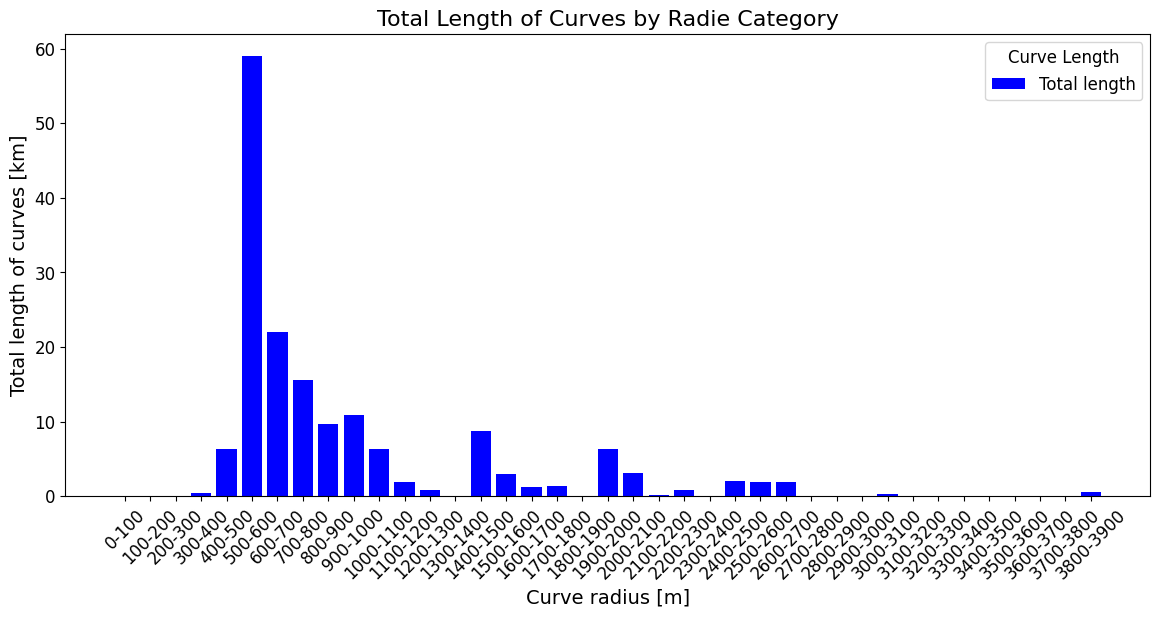

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming `df` is the DataFrame

# Step 1: Aggregate data by unique curves
df_agg = df.groupby(['Bandel', 'Startläge', 'Slutläge']).agg({
    'Radie_Abs_Value': 'first',  # Retain the first (unique for each curve)
    'length': 'first'  # Take the first length value (avoiding duplicates)
}).reset_index()

# Step 2: Convert length to kilometers
df_agg['length'] = df_agg['length'] / 1000  # Convert meters to kilometers

# Step 3: Define categories for `Radie` (Curve radius) with 100m increments
bins = np.arange(0, 4000, 100)  # Radius bins from 0 to 4000 in steps of 100
labels = [f'{bins[i]}-{bins[i + 1]}' for i in range(len(bins) - 1)]  # Create interval labels
df_agg['Radie Category'] = pd.cut(df_agg['Radie_Abs_Value'], bins=bins, labels=labels, right=False)

# Step 4: Group aggregated data by `Radie Category`, summing unique lengths
grouped = df_agg.groupby(['Radie Category'], observed=False)['length'].sum()

# Step 5: Prepare data for plotting
R_cat = np.arange(len(grouped.index))  # One bar per Radie Category
width = 0.8  # Bar width

# Step 6: Plot the bar chart
plt.figure(figsize=(14, 6))
ax = plt.axes()

# Bar plot
ax.bar(R_cat, grouped.values, width=width, color='b', label='Total length')

# Step 7: Customize plot
plt.xticks(R_cat, grouped.index, rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Total length of curves [km]', fontsize=14)
plt.xlabel('Curve radius [m]', fontsize=14)
plt.legend(fontsize=12, title='Curve Length', title_fontsize=12)
plt.title('Total Length of Curves by Radie Category', fontsize=16)

# Optional: Save the figure
# plt.savefig('length_per_radie_category_plot.svg', bbox_inches='tight')

# Show the plot
plt.show()


### Plotting distribution of installment year (per curve radie interval)

In [67]:
# Assuming `combined_dataframe` is the DataFrame
df = combined_dataframe.copy()

# Drop rows with NaN values in either of the columns
df = df.dropna(subset=['Räl Inläggningsår Innersträng', 'Räl Inläggningsår Yttersträng'])

# Step 4: Now convert to integer (after cleaning)
df['Räl Inläggningsår Innersträng'] = df['Räl Inläggningsår Innersträng'].astype(int)
df['Räl Inläggningsår Yttersträng'] = df['Räl Inläggningsår Yttersträng'].astype(int)

df = df.drop_duplicates(subset=['Bandel', 'Startläge', 'Slutläge'])

C:\Users\AbdouAA\AppData\Local\Temp\ipykernel_16296\1167430806.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = df_filtered.groupby(['Räl Inläggningsår Innersträng', 'Radius Interval'])['length_km'].sum().unstack(fill_value=0)


<Figure size 1400x600 with 0 Axes>

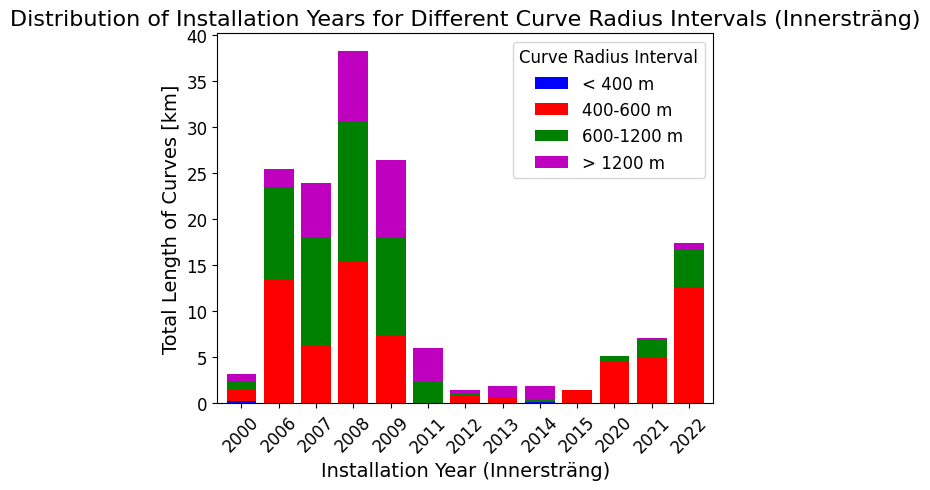

In [68]:
# Step 1: Create custom curve radius intervals
radius_bins = [float('-inf'), 400, 600, 1200, float('inf')]
radius_labels = ['< 400 m', '400-600 m', '600-1200 m', '> 1200 m']

# Categorize the data by the defined radius intervals
df['Radius Interval'] = pd.cut(df['Radie_Abs_Value'], bins=radius_bins, labels=radius_labels)

# Step 2: Drop rows with missing or invalid installation years
df_filtered = df.dropna(subset=['Räl Inläggningsår Innersträng'])
df_filtered = df_filtered[df_filtered['Räl Inläggningsår Innersträng'].astype(int) != 0]

# Convert installation year to integer
df_filtered['Räl Inläggningsår Innersträng'] = df_filtered['Räl Inläggningsår Innersträng'].astype(int)

# Step 3: Convert length to kilometers
df_filtered['length_km'] = df_filtered['length'] / 1000

# Step 4: Group by installation year and radius interval, summing the lengths in km
grouped_data = df_filtered.groupby(['Räl Inläggningsår Innersträng', 'Radius Interval'])['length_km'].sum().unstack(fill_value=0)

# Step 5: Filter out years with a total length of less than 1 km
grouped_data = grouped_data[grouped_data.sum(axis=1) >= 1]

# Step 6: Plot the stacked bar chart
plt.figure(figsize=(14, 6))
grouped_data.plot(kind='bar', stacked=True, color=['b', 'r', 'g', 'm'], width=0.8)

# Customize the plot
plt.xlabel('Installation Year (Innersträng)', fontsize=14)
plt.ylabel('Total Length of Curves [km]', fontsize=14)
plt.title('Distribution of Installation Years for Different Curve Radius Intervals (Innersträng)', fontsize=16)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.legend(title='Curve Radius Interval', title_fontsize=12, fontsize=12)

# Optional: Save the figure
# plt.savefig('installation_years_curve_radius_innerstrang_km.svg', bbox_inches='tight')

# Show the plot
plt.show()


C:\Users\AbdouAA\AppData\Local\Temp\ipykernel_16296\2113081295.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = df_filtered.groupby(['Räl Inläggningsår Yttersträng', 'Radius Interval'])['length_km'].sum().unstack(fill_value=0)


<Figure size 1400x600 with 0 Axes>

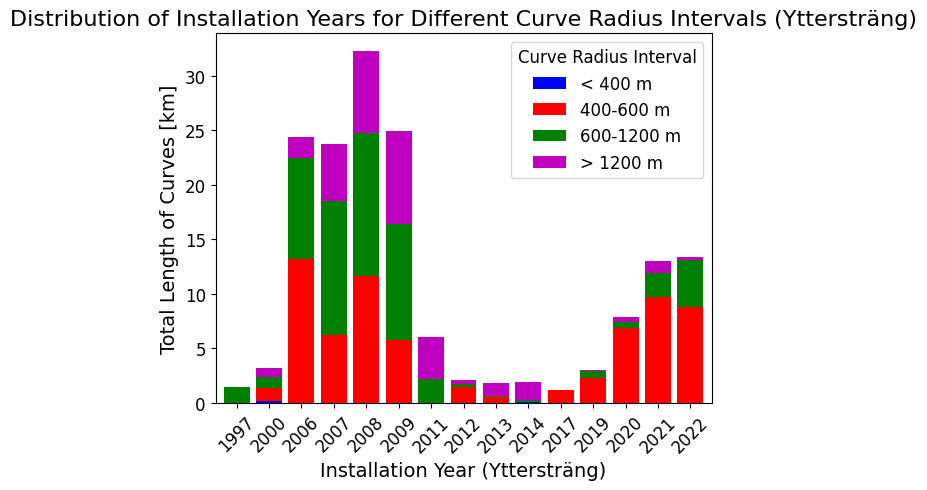

In [69]:
# Step 1: Create custom curve radius intervals
radius_bins = [float('-inf'), 400, 600, 1200, float('inf')]
radius_labels = ['< 400 m', '400-600 m', '600-1200 m', '> 1200 m']

# Categorize the data by the defined radius intervals
df['Radius Interval'] = pd.cut(df['Radie_Abs_Value'], bins=radius_bins, labels=radius_labels)

# Step 2: Drop rows with missing or invalid installation years
df_filtered = df.dropna(subset=['Räl Inläggningsår Yttersträng'])
df_filtered = df_filtered[df_filtered['Räl Inläggningsår Yttersträng'].astype(int) != 0]

# Convert installation year to integer
df_filtered['Räl Inläggningsår Yttersträng'] = df_filtered['Räl Inläggningsår Yttersträng'].astype(int)

# Step 3: Convert length to kilometers
df_filtered['length_km'] = df_filtered['length'] / 1000

# Step 4: Group by installation year and radius interval, summing the lengths in km
grouped_data = df_filtered.groupby(['Räl Inläggningsår Yttersträng', 'Radius Interval'])['length_km'].sum().unstack(fill_value=0)

# Step 5: Filter out years with a total length of less than 1 km
grouped_data = grouped_data[grouped_data.sum(axis=1) >= 1]

# Step 6: Plot the stacked bar chart
plt.figure(figsize=(14, 6))
grouped_data.plot(kind='bar', stacked=True, color=['b', 'r', 'g', 'm'], width=0.8)

# Customize the plot
plt.xlabel('Installation Year (Yttersträng)', fontsize=14)
plt.ylabel('Total Length of Curves [km]', fontsize=14)
plt.title('Distribution of Installation Years for Different Curve Radius Intervals (Yttersträng)', fontsize=16)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.legend(title='Curve Radius Interval', title_fontsize=12, fontsize=12)

# Optional: Save the figure
# plt.savefig('installation_years_curve_radius_innerstrang_km.svg', bbox_inches='tight')

# Show the plot
plt.show()


### Plotting distribution of curve radie interval (per categorie of installment year)

We will now plot the same distribution per year of installment Räl Inläggningsår Innersträng and another using Räl Inläggningsår Ytersträng.



C:\Users\AbdouAA\AppData\Local\Temp\ipykernel_16296\3205155408.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_inner = df_agg_inner.groupby(['Radie Category', 'Year Category Innersträng'])['length'].sum().unstack(fill_value=0)


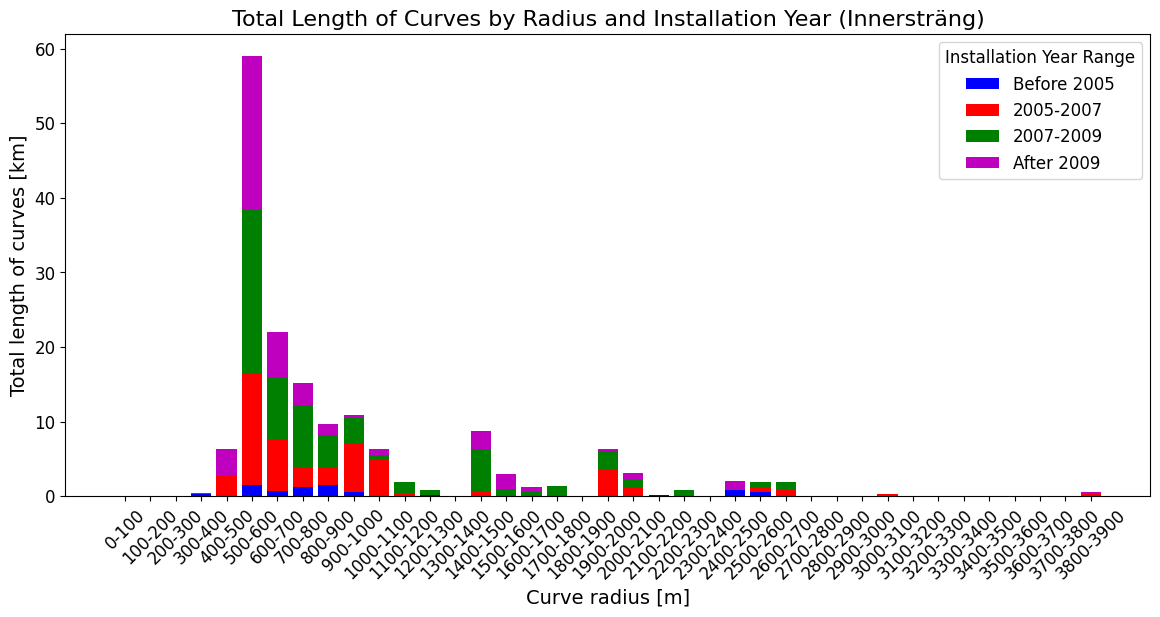

In [70]:
# Assuming `combined_dataframe` is the DataFrame
df = combined_dataframe.copy()

df = df.drop_duplicates(subset=['Bandel', 'Startläge', 'Slutläge'])

# Step 2: Create custom year intervals for Innersträng
bins = [float('-inf'), 2005, 2007, 2009, float('inf')]  # Define the year intervals
labels = ['Before 2005', '2005-2007', '2007-2009', 'After 2009']  # Labels for each interval

# Add a new column 'Year Category' to categorize the years into the intervals
df['Year Category Innersträng'] = pd.cut(df['Räl Inläggningsår Innersträng'], bins=bins, labels=labels)

# Step 3: Aggregate data by unique curves, including Radie and Year Category for Innersträng
df_agg_inner = df.groupby(['Bandel', 'Startläge', 'Slutläge']).agg({
    'Radie_Abs_Value': 'first',  # Retain the first (unique for each curve)
    'length': 'first',  # Take the first length value (avoiding duplicates)
    'Year Category Innersträng': 'first'  # Year category for Innersträng
}).reset_index()

# Step 4: Convert length to kilometers
df_agg_inner['length'] = df_agg_inner['length'] / 1000  # Convert meters to kilometers

# Step 5: Define categories for `Radie` (Curve radius) with 100m increments
bins = np.arange(0, 4000, 100)  # Radius bins from 0 to 4000 in steps of 100
labels = [f'{bins[i]}-{bins[i + 1]}' for i in range(len(bins) - 1)]  # Create interval labels
df_agg_inner['Radie Category'] = pd.cut(df_agg_inner['Radie_Abs_Value'], bins=bins, labels=labels, right=False)

# Step 6: Group by `Radie Category` and `Year Category Innersträng`, summing the lengths
grouped_inner = df_agg_inner.groupby(['Radie Category', 'Year Category Innersträng'])['length'].sum().unstack(fill_value=0)

# Step 7: Prepare data for plotting
R_cat = np.arange(len(grouped_inner.index))  # One bar per Radie Category
width = 0.8  # Bar width

# Convert the grouped DataFrame into a NumPy array for stacking
stack_data = grouped_inner.values

# Step 8: Plot the stacked bar chart with selected colors
plt.figure(figsize=(14, 6))
ax = plt.axes()

# Stacked bar plot
bottoms = np.zeros(len(R_cat))  # Initialize the bottom positions for stacking
categories = grouped_inner.columns  # Year categories

# Custom colors for the selected intervals
colors = ['b', 'r', 'g', 'm']  # Colors for 4 selected intervals

for i, category in enumerate(categories):
    ax.bar(
        R_cat,
        stack_data[:, i],
        width=width,
        bottom=bottoms,
        color=colors[i],
        label=f'{category}'
    )
    bottoms += stack_data[:, i]  # Update bottom for the next stack

# Step 9: Customize plot
plt.xticks(R_cat, grouped_inner.index, rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Total length of curves [km]', fontsize=14)
plt.xlabel('Curve radius [m]', fontsize=14)
plt.legend(fontsize=12, title='Installation Year Range', title_fontsize=12)
plt.title('Total Length of Curves by Radius and Installation Year (Innersträng)', fontsize=16)

# Optional: Save the figure
# plt.savefig('stacked_curve_length_plot_innerstrang_selected_intervals.svg', bbox_inches='tight')

# Show the plot
plt.show()

C:\Users\AbdouAA\AppData\Local\Temp\ipykernel_16296\1166482628.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_inner = df_agg_inner.groupby(['Radie Category', 'Year Category Yttersträng'])['length'].sum().unstack(fill_value=0)


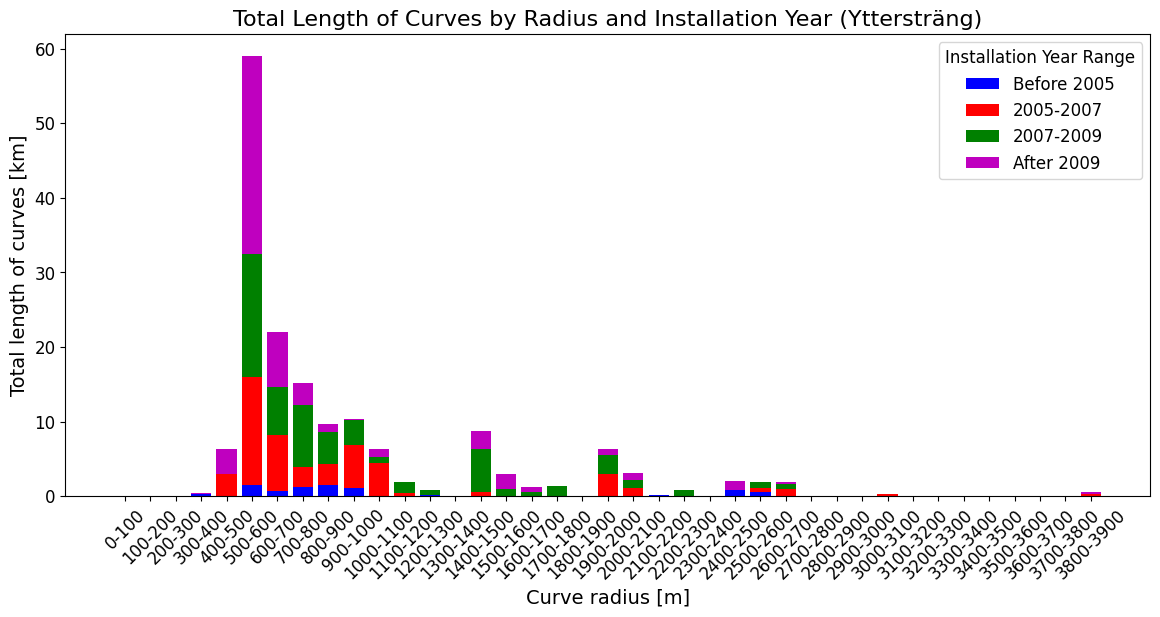

In [71]:
# Assuming `combined_dataframe` is the DataFrame
df = combined_dataframe.copy()
df = df.drop_duplicates(subset=['Bandel', 'Startläge', 'Slutläge'])

# Step 2: Create custom year intervals for Innersträng
bins = [float('-inf'), 2005, 2007, 2009, float('inf')]  # Define the year intervals
labels = ['Before 2005', '2005-2007', '2007-2009', 'After 2009']  # Labels for each interval

# Add a new column 'Year Category' to categorize the years into the intervals
df['Year Category Yttersträng'] = pd.cut(df['Räl Inläggningsår Yttersträng'], bins=bins, labels=labels)

# Step 3: Aggregate data by unique curves, including Radie and Year Category for Innersträng
df_agg_inner = df.groupby(['Bandel', 'Startläge', 'Slutläge']).agg({
    'Radie_Abs_Value': 'first',  # Retain the first (unique for each curve)
    'length': 'first',  # Take the first length value (avoiding duplicates)
    'Year Category Yttersträng': 'first'  # Year category for Innersträng
}).reset_index()

# Step 4: Convert length to kilometers
df_agg_inner['length'] = df_agg_inner['length'] / 1000  # Convert meters to kilometers

# Step 5: Define categories for `Radie` (Curve radius) with 100m increments
bins = np.arange(0, 4000, 100)  # Radius bins from 0 to 4000 in steps of 100
labels = [f'{bins[i]}-{bins[i + 1]}' for i in range(len(bins) - 1)]  # Create interval labels
df_agg_inner['Radie Category'] = pd.cut(df_agg_inner['Radie_Abs_Value'], bins=bins, labels=labels, right=False)

# Step 6: Group by `Radie Category` and `Year Category Innersträng`, summing the lengths
grouped_inner = df_agg_inner.groupby(['Radie Category', 'Year Category Yttersträng'])['length'].sum().unstack(fill_value=0)

# Step 7: Prepare data for plotting
R_cat = np.arange(len(grouped_inner.index))  # One bar per Radie Category
width = 0.8  # Bar width

# Convert the grouped DataFrame into a NumPy array for stacking
stack_data = grouped_inner.values

# Step 8: Plot the stacked bar chart with selected colors
plt.figure(figsize=(14, 6))
ax = plt.axes()

# Stacked bar plot
bottoms = np.zeros(len(R_cat))  # Initialize the bottom positions for stacking
categories = grouped_inner.columns  # Year categories

# Custom colors for the selected intervals
colors = ['b', 'r', 'g', 'm']  # Colors for 4 selected intervals

for i, category in enumerate(categories):
    ax.bar(
        R_cat,
        stack_data[:, i],
        width=width,
        bottom=bottoms,
        color=colors[i],
        label=f'{category}'
    )
    bottoms += stack_data[:, i]  # Update bottom for the next stack

# Step 9: Customize plot
plt.xticks(R_cat, grouped_inner.index, rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Total length of curves [km]', fontsize=14)
plt.xlabel('Curve radius [m]', fontsize=14)
plt.legend(fontsize=12, title='Installation Year Range', title_fontsize=12)
plt.title('Total Length of Curves by Radius and Installation Year (Yttersträng)', fontsize=16)

# Optional: Save the figure
# plt.savefig('stacked_curve_length_plot_innerstrang_selected_intervals.svg', bbox_inches='tight')

# Show the plot
plt.show()